Objective: 

Develop a machine learning classification model to predict whether a customer is likely to 
default on their credit card payment in the next month. The goal is to train, validate, and 
evaluate two classification models: a Decision Tree Classifier and a Logistic Regression 
model.

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
import joblib

sns.set(style="whitegrid")
RANDOM_STATE = 42


In [8]:
file_path = r"C:\Users\vedha\OneDrive\Desktop\Assignment-2\default of credit card clients.xls"

def load_credit_data(path):
    name_lower = path.lower()
    if name_lower.endswith(".csv"):
        df = pd.read_csv(path)
    else:
        df = pd.read_excel(path, header=1, engine="xlrd")  # header=1 matches UCI dataset
    return df

df = load_credit_data(file_path)
print("Loaded shape:", df.shape)
df.head()


Loaded shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [9]:
print(df.info())
print(df.isnull().sum())

if 'ID' in df.columns:
    df = df.drop(columns=['ID'])

target_col = [c for c in df.columns if 'default' in c.lower()][0]
print("Target column:", target_col)

print(df[target_col].value_counts(normalize=True))

df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


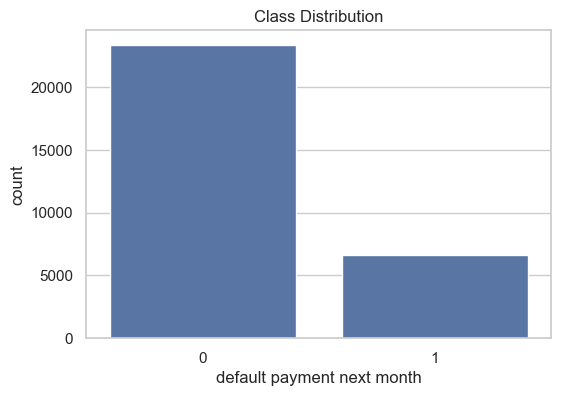

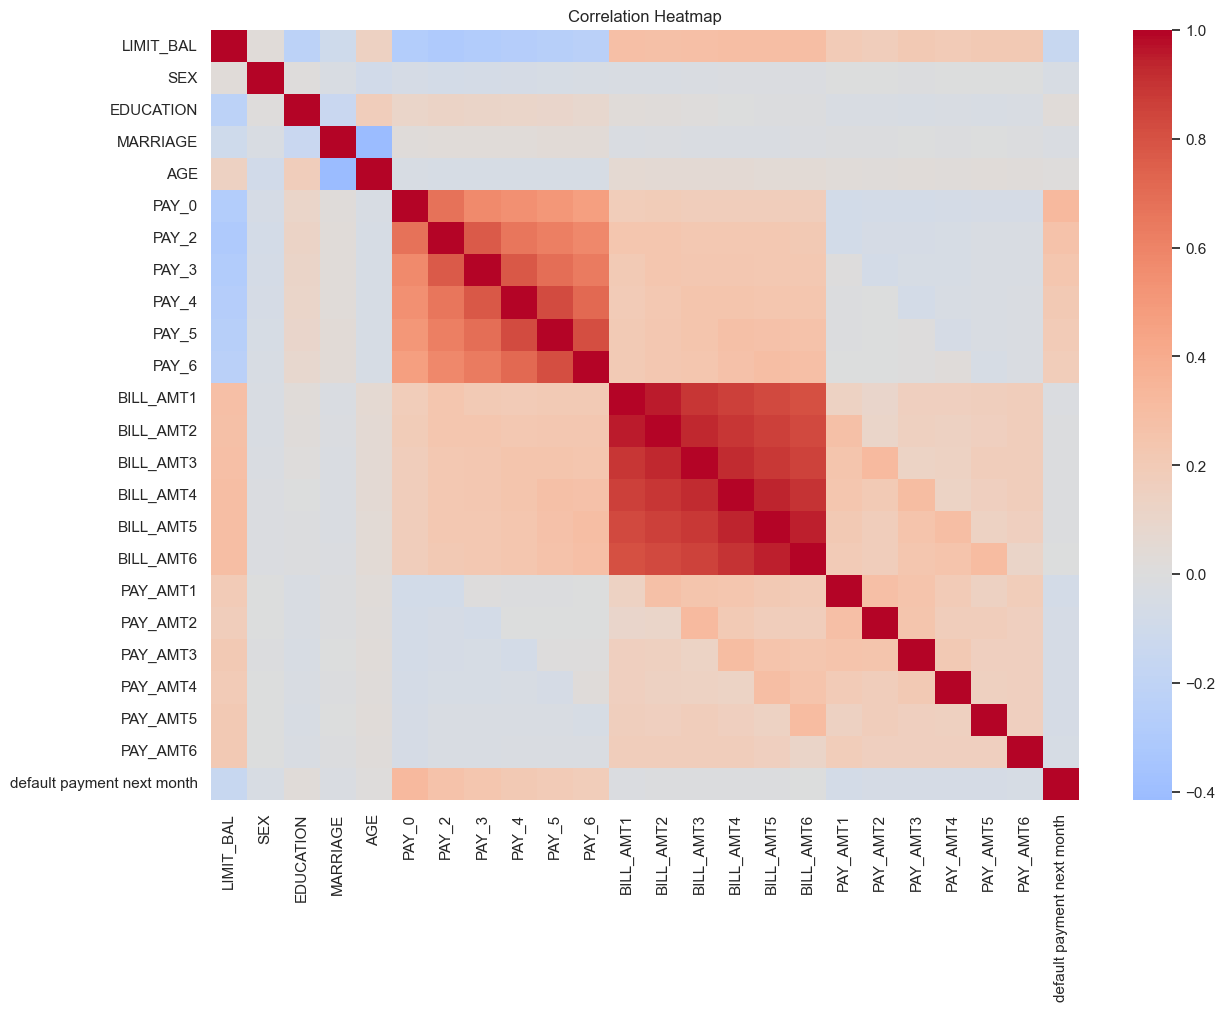

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df)
plt.title("Class Distribution")
plt.show()

corr = df.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


In [11]:
df[target_col] = df[target_col].astype(int)

categorical_features = [c for c in ['SEX','EDUCATION','MARRIAGE'] if c in df.columns]
numeric_features = [c for c in df.columns if c not in categorical_features+[target_col]]

if 'EDUCATION' in df.columns:
    df['EDUCATION'] = df['EDUCATION'].replace({0:4, 5:4, 6:4})
if 'MARRIAGE' in df.columns:
    df['MARRIAGE'] = df['MARRIAGE'].replace({0:3})

df.to_csv("cleaned_creditcard.csv", index=False)
print("Cleaned dataset saved as cleaned_creditcard.csv")


Cleaned dataset saved as cleaned_creditcard.csv


In [12]:
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (24000, 23) Test shape: (6000, 23)


In [13]:
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features)
])

dt_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

lr_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(solver='liblinear', max_iter=2000, random_state=RANDOM_STATE))
])


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

dt_param_grid = {
    'clf__max_depth': [3,5,7,10,None],
    'clf__min_samples_split': [2,5,10]
}

lr_param_grid = {
    'clf__penalty': ['l1','l2'],
    'clf__C': [0.01,0.1,1,10]
}

dt_grid = GridSearchCV(dt_pipeline, dt_param_grid, cv=skf, scoring='roc_auc', n_jobs=-1)
dt_grid.fit(X_train, y_train)

lr_grid = GridSearchCV(lr_pipeline, lr_param_grid, cv=skf, scoring='roc_auc', n_jobs=-1)
lr_grid.fit(X_train, y_train)

print("Best DT params:", dt_grid.best_params_)
print("Best LR params:", lr_grid.best_params_)


In [ ]:
best_dt = dt_grid.best_estimator_
best_lr = lr_grid.best_estimator_

def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"=== {name} ===")
    print("Accuracy:", accuracy_score(y_test,y_pred))
    print("Precision:", precision_score(y_test,y_pred))
    print("Recall:", recall_score(y_test,y_pred))
    print("F1:", f1_score(y_test,y_pred))
    print("ROC AUC:", roc_auc_score(y_test,y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    return y_proba

dt_proba = evaluate(best_dt, X_test, y_test, "Decision Tree")
lr_proba = evaluate(best_lr, X_test, y_test, "Logistic Regression")



In [ ]:
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_proba)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, label="Decision Tree")
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


In [ ]:
joblib.dump(best_dt, "best_decision_tree.joblib")
joblib.dump(best_lr, "best_logistic_regression.joblib")
print("Models saved in current folder.")
